In [3]:
import os
# Check if we're in the root directory of rl-llm repo
if not os.path.basename(os.getcwd()) == 'rl-llm':
    # If we're in a subdirectory of rl-llm, find the root and cd to it
    current_path = os.getcwd()
    while os.path.basename(current_path) != 'rl-llm' and os.path.dirname(current_path) != current_path:
        current_path = os.path.dirname(current_path)
    
    if os.path.basename(current_path) == 'rl-llm':
        os.chdir(current_path)
        print(f"Changed directory to: {current_path}")
    else:
        print("Not in rl-llm repository structure")
else:
    print("Already in rl-llm root directory")

print(f"Current directory: {os.getcwd()}")

Already in rl-llm root directory
Current directory: /workspace/rl-llm


In [8]:
# Import necessary libraries
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from src import EnvManager, sample_episodes
import babyai_text
from peft import PeftModel, PeftConfig
from typing import Dict, Any, List, Union
from transformers import AutoTokenizer
from trl import AutoModelForCausalLMWithValueHead
import logging
import os
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [9]:
# Set PyTorch CUDA allocator config to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Suppress transformers logging to ERROR level
logging.getLogger("transformers").setLevel(logging.ERROR)

# Configure logging
logging.basicConfig(
    filename="outputs/logs/evaluation.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# Register levels for logging
babyai_text.register_levels(__name__, globals())

In [10]:
# Evaluate a model on a single environment
def evaluate(
    model,
    tokenizer,
    env_id: str,
    context_window: int,
    num_envs: int = 6,
    num_episodes: int = 40,
    reasoning_flag: bool = False,
    generation_kwargs: dict = None,
    device: torch.device = None,
    invalid_action_penalty: float = -1,
    consecutive_invalid_actions_allowed: int = 5,
    model_name: str = "model",
    step_offset: int = 0, # count the number of steps from the start of the episode
    num_dists: int = 0, # number of distractors
) -> Dict[str, Any]:
    if generation_kwargs is None:
        generation_kwargs = {
            "max_new_tokens": 20,
            "do_sample": True,
            "top_k": 50,
            "top_p": 0.9,
            "temperature": 0.7,
        }

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logging.info(f"Evaluating {model_name} on {env_id} with {num_episodes} episodes (reasoning={reasoning_flag}, num_dists={num_dists})")
    print(f"Evaluating {model_name} on {env_id} with {num_episodes} episodes (reasoning={reasoning_flag}, num_dists={num_dists})...")

    model.to(device)
    model.eval()

    if not hasattr(model, "generation_config"):
        from transformers import GenerationConfig
        model.generation_config = GenerationConfig(**generation_kwargs)

    envs = [
        EnvManager(
            env_ids=[env_id],
            num_dists=num_dists,  # Pass num_dists to EnvManager
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            reasoning_flag=reasoning_flag
        )
        for _ in range(num_envs)
    ]

    eval_start_time = time.time()
    stats, contexts = sample_episodes(
        envs=envs,
        tokenizer=tokenizer,
        model=model,
        generation_kwargs=generation_kwargs,
        device=device,
        number_of_episodes=num_episodes,
        context_window=context_window,
        reasoning_flag=reasoning_flag,
    )
    eval_end_time = time.time()

    num_samples = len(stats["success"])
    if num_samples == 0:
        metrics = {
            "num_episodes": 0,
            "success_rate": 0.0,
            "success_rate_std": 0.0,
            "avg_reward": 0.0,
            "avg_reward_std": 0.0,
            "avg_steps": 0.0,
            "avg_steps_std": 0.0,
            "invalid_action_rate": 0.0,
            "invalid_action_rate_std": 0.0,
            "avg_steps_to_success": float("nan"),
            "avg_steps_to_success_std": float("nan"),
            "avg_total_time": 0.0,
            "avg_generate_time": 0.0,
        }
        logging.warning(f"No episodes completed for {model_name} on {env_id}")
        return {
            "final_metrics": metrics,
            "running_success_rates": [],
            "running_avg_rewards": [],
            "episode_times": [],
        }

    success_tensor = torch.tensor(stats["success"], dtype=torch.float32)
    reward_tensor = torch.tensor(stats["rewards"], dtype=torch.float32)
    length_tensor = torch.tensor(stats["episode_lengths"], dtype=torch.float32)
    invalid_tensor = torch.tensor(stats["num_invalid_actions"], dtype=torch.float32)

    success_rate = success_tensor.mean().item()
    success_rate_std = success_tensor.std().item() if num_samples > 1 else 0.0
    avg_reward = reward_tensor.mean().item()
    avg_reward_std = reward_tensor.std().item() if num_samples > 1 else 0.0
    avg_steps = length_tensor.mean().item()
    avg_steps_std = length_tensor.std().item() if num_samples > 1 else 0.0
    invalid_rate = invalid_tensor.mean().item()
    invalid_rate_std = invalid_tensor.std().item() if num_samples > 1 else 0.0

    successful_indices = (success_tensor == 1)
    if successful_indices.any():
        steps_for_successes = length_tensor[successful_indices]
        avg_steps_success = steps_for_successes.mean().item()
        avg_steps_success_std = steps_for_successes.std().item() if len(steps_for_successes) > 1 else 0.0
    else:
        avg_steps_success = float("nan")
        avg_steps_success_std = float("nan")

    total_time = eval_end_time - eval_start_time
    avg_generate_time = stats.get("total_generate_time", float("nan")) / num_samples if num_samples > 0 else float("nan")

    metrics = {
        "num_episodes": num_samples,
        "success_rate": success_rate,
        "success_rate_std": success_rate_std,
        "avg_reward": avg_reward,
        "avg_reward_std": avg_reward_std,
        "avg_steps": avg_steps,
        "avg_steps_std": avg_steps_std,
        "invalid_action_rate": invalid_rate,
        "invalid_action_rate_std": invalid_rate_std,
        "avg_steps_to_success": avg_steps_success,
        "avg_steps_to_success_std": avg_steps_success_std,
        "avg_total_time": total_time,
        "avg_total_time_std": 0.0,
        "avg_generate_time": avg_generate_time,
        "avg_generate_time_std": 0.0,
    }

    logging.info(f"Metrics for {model_name} on {env_id}: {metrics}")
    return {
        "final_metrics": metrics,
        "running_success_rates": [],
        "running_avg_rewards": [],
        "episode_times": [],
    }

In [11]:
# Function for plotting bar charts
def plot_performance(
    env_ids: List[str],
    context_window: int,
    baseline_non_reasoning_results: Dict[str, float],
    baseline_reasoning_results: Dict[str, float],
    reasoning_results: Dict[str, float],
    non_reasoning_results: Dict[str, float],
    env_type: str,
    checkpoint_name: str,
):
    fig, ax = plt.subplots(figsize=(12, 6))
    n_envs = len(env_ids)
    bar_width = 0.2
    index = np.arange(n_envs)

    ax.bar(index - bar_width * 1.5, [baseline_non_reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Baseline (Non-Reasoning)", color='red', alpha=0.7)
    ax.bar(index - bar_width * 0.5, [baseline_reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Baseline (Reasoning)", color='orange', alpha=0.7)
    ax.bar(index + bar_width * 0.5, [reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Reasoning (Trained)", color='blue', alpha=0.7)
    ax.bar(index + bar_width * 1.5, [non_reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Non-Reasoning (Trained)", color='green', alpha=0.7)

    ax.set_xlabel("Environments", fontsize=12)
    ax.set_ylabel("Success Rate", fontsize=12)
    ax.set_title(f"Model Performance Comparison (Checkpoint: {checkpoint_name}, Context Window: {context_window}, {env_type})", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(env_ids, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plot_path = f"outputs/plots/{env_type.lower()}_comparison_{checkpoint_name}_ctx{context_window}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    logging.info(f"Plot saved to {plot_path}")

In [12]:
# Function to evaluate multiple models on multiple environments
def evaluate_models(
    models_info: List[Dict[str, Any]],
    seen_env_ids: List[str],
    unseen_env_ids: List[str],
    context_window: int = 5,
    num_envs: int = 6,
    num_episodes: int = 40,
    generation_kwargs: dict = None,
    device: torch.device = None,
    invalid_action_penalty: float = -1,
    consecutive_invalid_actions_allowed: int = 5,
    step_offset: int = 0,
    num_dists: int = 0,
) -> tuple[Dict[str, Dict[str, Dict[int, Dict[str, Any]]]], Dict[str, Dict[str, Dict[int, Dict[str, Any]]]]]:
    if generation_kwargs is None:
        generation_kwargs = {
            "max_new_tokens": 20,
            "do_sample": True,
            "top_k": 50,
            "top_p": 0.9,
            "temperature": 0.7,
        }

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}
    current_step = step_offset

    # Find the baseline model
    baseline_model_info = None
    for model_info in models_info:
        if "baseline" in model_info['name'].lower():
            baseline_model_info = model_info
            break

    if baseline_model_info is None:
        raise ValueError("Baseline (untrained) model not found in models_info.")

    # Evaluate baseline model
    baseline_results = {"seen": {}, "unseen": {}}
    for env_id in seen_env_ids:
        baseline_results["seen"][env_id] = {}
        baseline_results["seen"][env_id][context_window] = {}
        print(f"\n=== Evaluating baseline model (non-reasoning) on seen env {env_id} with context {context_window} ===")
        non_reasoning_result = evaluate(
            model=baseline_model_info['model'],
            tokenizer=baseline_model_info['tokenizer'],
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=False,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-non-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        # Store full metrics instead of just success_rate
        baseline_results["seen"][env_id][context_window]["non_reasoning"] = non_reasoning_result["final_metrics"]
        current_step += num_episodes

        print(f"\n=== Evaluating baseline model (reasoning) on seen env {env_id} with context {context_window} ===")
        reasoning_result = evaluate(
            model=baseline_model_info['model'],
            tokenizer=baseline_model_info['tokenizer'],
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=True,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        # Store full metrics instead of just success_rate
        baseline_results["seen"][env_id][context_window]["reasoning"] = reasoning_result["final_metrics"]
        current_step += num_episodes

    for env_id in unseen_env_ids:
        baseline_results["unseen"][env_id] = {}
        baseline_results["unseen"][env_id][context_window] = {}
        print(f"\n=== Evaluating baseline model (non-reasoning) on unseen env {env_id} with context {context_window} ===")
        non_reasoning_result = evaluate(
            model=baseline_model_info['model'],
            tokenizer=baseline_model_info['tokenizer'],
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=False,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-non-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        # Store full metrics instead of just success_rate
        baseline_results["unseen"][env_id][context_window]["non_reasoning"] = non_reasoning_result["final_metrics"]
        current_step += num_episodes

        print(f"\n=== Evaluating baseline model (reasoning) on unseen env {env_id} with context {context_window} ===")
        reasoning_result = evaluate(
            model=baseline_model_info['model'],
            tokenizer=baseline_model_info['tokenizer'],
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=True,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        # Store full metrics instead of just success_rate
        baseline_results["unseen"][env_id][context_window]["reasoning"] = reasoning_result["final_metrics"]
        current_step += num_episodes

    # Evaluate trained models
    for model_info in models_info:
        if "baseline" in model_info['name'].lower():
            continue

        model = model_info['model']
        tokenizer = model_info['tokenizer']
        model_name = model_info['name']
        checkpoint_name = model_info.get('checkpoint_name', model_name)
        results[model_name] = {"seen": {}, "unseen": {}}

        for env_id in seen_env_ids:
            results[model_name]["seen"][env_id] = {}
            results[model_name]["seen"][env_id][context_window] = {}
            print(f"\n=== Evaluating {model_name} on seen env {env_id} with context {context_window} ===")
            reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=True,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-reasoning",
                step_offset=current_step,
                num_dists=num_dists,
            )
            non_reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=False,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-non-reasoning",
                step_offset=current_step + num_episodes,
                num_dists=num_dists,
            )
            results[model_name]["seen"][env_id][context_window] = {
                "reasoning": reasoning_result["final_metrics"],
                "non_reasoning": non_reasoning_result["final_metrics"],
            }
            current_step += 2 * num_episodes

        for env_id in unseen_env_ids:
            results[model_name]["unseen"][env_id] = {}
            results[model_name]["unseen"][env_id][context_window] = {}
            print(f"\n=== Evaluating {model_name} on unseen env {env_id} with context {context_window} ===")
            reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=True,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-reasoning",
                step_offset=current_step,
                num_dists=num_dists,
            )
            non_reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=False,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-non-reasoning",
                step_offset=current_step + num_episodes,
                num_dists=num_dists,
            )
            results[model_name]["unseen"][env_id][context_window] = {
                "reasoning": reasoning_result["final_metrics"],
                "non_reasoning": non_reasoning_result["final_metrics"],
            }
            current_step += 2 * num_episodes

        # Update plotting to use full metrics
        seen_baseline_non_reasoning = {env_id: baseline_results["seen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in seen_env_ids}
        seen_baseline_reasoning = {env_id: baseline_results["seen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in seen_env_ids}
        seen_reasoning = {env_id: results[model_name]["seen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in seen_env_ids}
        seen_non_reasoning = {env_id: results[model_name]["seen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in seen_env_ids}

        plot_performance(
            env_ids=seen_env_ids,
            context_window=context_window,
            baseline_non_reasoning_results=seen_baseline_non_reasoning,
            baseline_reasoning_results=seen_baseline_reasoning,
            reasoning_results=seen_reasoning,
            non_reasoning_results=seen_non_reasoning,
            env_type="Seen",
            checkpoint_name=checkpoint_name,
        )

        unseen_baseline_non_reasoning = {env_id: baseline_results["unseen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in unseen_env_ids}
        unseen_baseline_reasoning = {env_id: baseline_results["unseen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in unseen_env_ids}
        unseen_reasoning = {env_id: results[model_name]["unseen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in unseen_env_ids}
        unseen_non_reasoning = {env_id: results[model_name]["unseen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in unseen_env_ids}

        plot_performance(
            env_ids=unseen_env_ids,
            context_window=context_window,
            baseline_non_reasoning_results=unseen_baseline_non_reasoning,
            baseline_reasoning_results=unseen_baseline_reasoning,
            reasoning_results=unseen_reasoning,
            non_reasoning_results=unseen_non_reasoning,
            env_type="Unseen",
            checkpoint_name=checkpoint_name,
        )

    return results, baseline_results

In [13]:
# Load baseline model
baseline_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    "meta-llama/Llama-3.2-3B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)
baseline_tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-3.2-3B-Instruct",
    padding_side="left"
)

# Initialize models_info with baseline model
models_info = [
    {
        'model': baseline_model,
        'tokenizer': baseline_tokenizer,
        'name': 'llama-3.2-3b-baseline'
    }
]

# Checkpoints
checkpoints = [
    ("CatkinChen/final_runs-Reasoning_trial_2_dist_3", "5decb78a8bbe8aba19865a960c82a67b01a37167"),  # Checkpoint 340
]

# Add each checkpoint as a trained model
for idx, (checkpoint, commit_hash) in enumerate(checkpoints):
    peft_config = PeftConfig.from_pretrained(checkpoint, revision=commit_hash)
    peft_model = PeftModel.from_pretrained(baseline_model, checkpoint, revision=commit_hash)
    checkpoint_short_name = f"Checkpoint_{(340 - idx*10)}" # Change 340 to the final checkpoint number
    
    models_info.append({
        'model': peft_model,
        'tokenizer': baseline_tokenizer,
        'name': f'llama-3.2-3b-trained-{idx}',
        'checkpoint_name': checkpoint_short_name
    })

# Configure tokenizers and pad tokens
for model_info in models_info:
    model_info['model'].config.pad_token_id = model_info['tokenizer'].eos_token_id
    tokenizer = model_info['tokenizer']
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        print(f"Setting pad_token to eos_token for {model_info['name']}")

seen_env_ids = ["BabyAI-GoTo-v0", "BabyAI-Pickup-v0"]
unseen_env_ids = ["BabyAI-Open-v0", "BabyAI-PutNext-v0", "BabyAI-PickUpSeqGoTo-v0"]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting pad_token to eos_token for llama-3.2-3b-baseline


/workspace/rl-llm/.venv/lib/python3.10/site-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.pretrained_model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.2.self_attn.q_proj.lora_A.default.weight', 'base_model.model.pretrained_mode

In [14]:
# Run evaluation with a single context window
context_window = 5
results, baseline_results = evaluate_models(
    models_info=models_info,
    seen_env_ids=seen_env_ids,
    unseen_env_ids=unseen_env_ids,
    context_window=context_window,
    num_episodes=10,
    num_dists=3,
)


=== Evaluating baseline model (non-reasoning) on seen env BabyAI-GoTo-v0 with context 5 ===
Evaluating llama-3.2-3b-baseline-non-reasoning on BabyAI-GoTo-v0 with 10 episodes (reasoning=False, num_dists=3)...
1 2 3 4 5 6 7 8 9 10 

=== Evaluating baseline model (reasoning) on seen env BabyAI-GoTo-v0 with context 5 ===
Evaluating llama-3.2-3b-baseline-reasoning on BabyAI-GoTo-v0 with 10 episodes (reasoning=True, num_dists=3)...
1 2 3 4 5 6 7 8 9 10 

=== Evaluating baseline model (non-reasoning) on seen env BabyAI-Pickup-v0 with context 5 ===
Evaluating llama-3.2-3b-baseline-non-reasoning on BabyAI-Pickup-v0 with 10 episodes (reasoning=False, num_dists=3)...
1 2 3 4 5 6 7 8 9 10 

=== Evaluating baseline model (reasoning) on seen env BabyAI-Pickup-v0 with context 5 ===
Evaluating llama-3.2-3b-baseline-reasoning on BabyAI-Pickup-v0 with 10 episodes (reasoning=True, num_dists=3)...
1 2 3 4 5 6 7 8 9 10 

=== Evaluating baseline model (non-reasoning) on unseen env BabyAI-Open-v0 with conte

llama-3.2-3b-trained-0 on BabyAI-GoTo-v0 (seen) with context 5:
  reasoning:
    success_rate: 0.6000 ± 0.5164
    avg_reward: 0.5578 ± 0.4816
    avg_steps: 5.4000 ± 2.9515
    invalid_action_rate: 2.3000 ± 3.0930
    avg_steps_to_success: 5.0000 ± 3.5777
    avg_total_time: 11.5411 ± 0.0000
    avg_generate_time: 1.1448 ± 0.0000
  non_reasoning:
    success_rate: 1.0000 ± 0.0000
    avg_reward: 0.6822 ± 0.2272
    avg_steps: 22.9000 ± 16.4077
    invalid_action_rate: 0.3000 ± 0.6749
    avg_steps_to_success: 22.9000 ± 16.4077
    avg_total_time: 11.1377 ± 0.0000
    avg_generate_time: 1.0862 ± 0.0000


llama-3.2-3b-trained-0 on BabyAI-Pickup-v0 (seen) with context 5:
  reasoning:
    success_rate: 0.2000 ± 0.4216
    avg_reward: 0.1325 ± 0.2813
    avg_steps: 17.5000 ± 13.0746
    invalid_action_rate: 5.9000 ± 3.2472
    avg_steps_to_success: 26.0000 ± 9.8995
    avg_total_time: 43.8489 ± 0.0000
    avg_generate_time: 4.3605 ± 0.0000
  non_reasoning:
    success_rate: 0.7000 ± 0.4830
    avg_reward: 0.4314 ± 0.3545
    avg_steps: 40.7000 ± 24.5223
    invalid_action_rate: 2.4000 ± 5.4610
    avg_steps_to_success: 30.7143 ± 22.6768
    avg_total_time: 17.1615 ± 0.0000
    avg_generate_time: 1.6755 ± 0.0000


llama-3.2-3b-trained-0 on BabyAI-Open-v0 (unseen) with context 5:
  reasoning:
    success_rate: 0.0000 ± 0.0000
    avg_reward: 0.0000 ± 0.0000
    avg_steps: 68.7273 ± 59.8967
    invalid_action_rate: 4.9091 ± 4.4599
    avg_steps_to_success: nan ± nan
    avg_total_time: 113.9577 ± 0.0000
    avg_generate_time: 10.3007 ± 0.0000
  non_reasoning:
    success_rate: 0.1000 ± 0.3162
    avg_reward: 0.0452 ± 0.1428
    avg_steps: 117.1000 ± 34.3364
    invalid_action_rate: 4.2000 ± 3.8528
    avg_steps_to_success: 78.0000 ± 0.0000
    avg_total_time: 66.0037 ± 0.0000
    avg_generate_time: 6.4973 ± 0.0000


llama-3.2-3b-trained-0 on BabyAI-PutNext-v0 (unseen) with context 5:
  reasoning:
    success_rate: 0.0000 ± 0.0000
    avg_reward: 0.0000 ± 0.0000
    avg_steps: 53.0000 ± 56.5135
    invalid_action_rate: 7.0000 ± 5.1640
    avg_steps_to_success: nan ± nan
    avg_total_time: 105.9244 ± 0.0000
    avg_generate_time: 10.5314 ± 0.0000
  non_reasoning:
    success_rate: 0.1000 ± 0.3162
    avg_reward: 0.0290 ± 0.0917
    avg_steps: 130.1000 ± 7.7953
    invalid_action_rate: 4.8000 ± 3.6148
    avg_steps_to_success: 110.0000 ± 0.0000
    avg_total_time: 49.4958 ± 0.0000
    avg_generate_time: 4.8447 ± 0.0000


llama-3.2-3b-trained-0 on BabyAI-PickUpSeqGoTo-v0 (unseen) with context 5:
  reasoning:
    success_rate: 0.3000 ± 0.4830
    avg_reward: 0.1959 ± 0.3285
    avg_steps: 33.8000 ± 42.2237
    invalid_action_rate: 4.1000 ± 1.9692
    avg_steps_to_success: 51.3333 ± 29.4845
    avg_total_time: 95.9276 ± 0.0000
    avg_generate_time: 9.5372 ± 0.0000
  non_reasoning:
    success_rate: 0.1000 ± 0.3162
    avg_reward: 0.0852 ± 0.2695
    avg_steps: 119.6000 ± 34.3712
    invalid_action_rate: 2.3000 ± 2.3594
    avg_steps_to_success: 22.0000 ± 0.0000
    avg_total_time: 51.1736 ± 0.0000
    avg_generate_time: 5.0117 ± 0.0000


llama-3.2-3b-baseline on BabyAI-GoTo-v0 (seen) with context 5:
  non_reasoning:
    num_episodes: 10.0000
    success_rate: 1.0000 ± 0.0000
    avg_reward: 0.6766 ± 0.1840
    avg_steps: 23.2000 ± 13.0537
    invalid_action_rate: 0.2000 ± 0.4216
    avg_steps_to_success: 23.2000 ± 13.0537
    avg_total_time: 9.6639 ± 0.0000
    avg_generate_time: 0.9414 ± 0.0000
  reasoning:
    num_episodes: 10.0000
    success_rate: 0.4000 ± 0.5164
    avg_reward: 0.2720 ± 0.3703
    avg_steps: 31.1000 ± 20.5343
    invalid_action_rate: 4.7000 ± 4.3982
    avg_steps_to_success: 24.2500 ± 15.7771
    avg_total_time: 47.6489 ± 0.0000
    avg_generate_time: 4.7368 ± 0.0000


llama-3.2-3b-baseline on BabyAI-Pickup-v0 (seen) with context 5:
  non_reasoning:
    num_episodes: 10.0000
    success_rate: 0.4000 ± 0.5164
    avg_reward: 0.2383 ± 0.3595
    avg_steps: 51.8000 ± 23.9435
    invalid_action_rate: 1.9000 ± 4.0947
    avg_steps_to_success: 29.0000 ± 22.8181
    avg_total_time: 22.1155 ± 0.0000
    avg_generate_time: 2.1621 ± 0.0000
  reasoning:
    num_episodes: 10.0000
    success_rate: 0.3000 ± 0.4830
    avg_reward: 0.2592 ± 0.4202
    avg_steps: 22.5000 ± 23.3916
    invalid_action_rate: 4.0000 ± 4.4222
    avg_steps_to_success: 11.0000 ± 7.5498
    avg_total_time: 46.4839 ± 0.0000
    avg_generate_time: 4.6209 ± 0.0000


llama-3.2-3b-baseline on BabyAI-Open-v0 (unseen) with context 5:
  non_reasoning:
    num_episodes: 10.0000
    success_rate: 0.3000 ± 0.4830
    avg_reward: 0.1038 ± 0.1867
    avg_steps: 123.5000 ± 22.9795
    invalid_action_rate: 6.0000 ± 5.7927
    avg_steps_to_success: 98.0000 ± 29.2062
    avg_total_time: 48.6894 ± 0.0000
    avg_generate_time: 4.7680 ± 0.0000
  reasoning:
    num_episodes: 10.0000
    success_rate: 0.0000 ± 0.0000
    avg_reward: 0.0000 ± 0.0000
    avg_steps: 59.4000 ± 59.1518
    invalid_action_rate: 6.3000 ± 2.5841
    avg_steps_to_success: nan ± nan
    avg_total_time: 100.1223 ± 0.0000
    avg_generate_time: 9.9570 ± 0.0000


llama-3.2-3b-baseline on BabyAI-PutNext-v0 (unseen) with context 5:
  non_reasoning:
    num_episodes: 10.0000
    success_rate: 0.3000 ± 0.4830
    avg_reward: 0.1418 ± 0.2576
    avg_steps: 113.4000 ± 31.4932
    invalid_action_rate: 1.3000 ± 1.5670
    avg_steps_to_success: 75.0000 ± 36.0000
    avg_total_time: 49.9044 ± 0.0000
    avg_generate_time: 4.8854 ± 0.0000
  reasoning:
    num_episodes: 10.0000
    success_rate: 0.1000 ± 0.3162
    avg_reward: 0.0409 ± 0.1295
    avg_steps: 34.1000 ± 31.8380
    invalid_action_rate: 6.6000 ± 2.2706
    avg_steps_to_success: 86.0000 ± 0.0000
    avg_total_time: 84.7607 ± 0.0000
    avg_generate_time: 8.4288 ± 0.0000


llama-3.2-3b-baseline on BabyAI-PickUpSeqGoTo-v0 (unseen) with context 5:
  non_reasoning:
    num_episodes: 10.0000
    success_rate: 0.2000 ± 0.4216
    avg_reward: 0.0826 ± 0.1741
    avg_steps: 119.9000 ± 18.9529
    invalid_action_rate: 0.8000 ± 1.0328
    avg_steps_to_success: 84.0000 ± 1.4142
    avg_total_time: 49.9530 ± 0.0000
    avg_generate_time: 4.8891 ± 0.0000
  reasoning:
    num_episodes: 10.0000
    success_rate: 0.1000 ± 0.3162
    avg_reward: 0.0937 ± 0.2962
    avg_steps: 69.9000 ± 58.2398
    invalid_action_rate: 3.4000 ± 2.3664
    avg_steps_to_success: 9.0000 ± 0.0000
    avg_total_time: 98.3294 ± 0.0000
    avg_generate_time: 9.7751 ± 0.0000


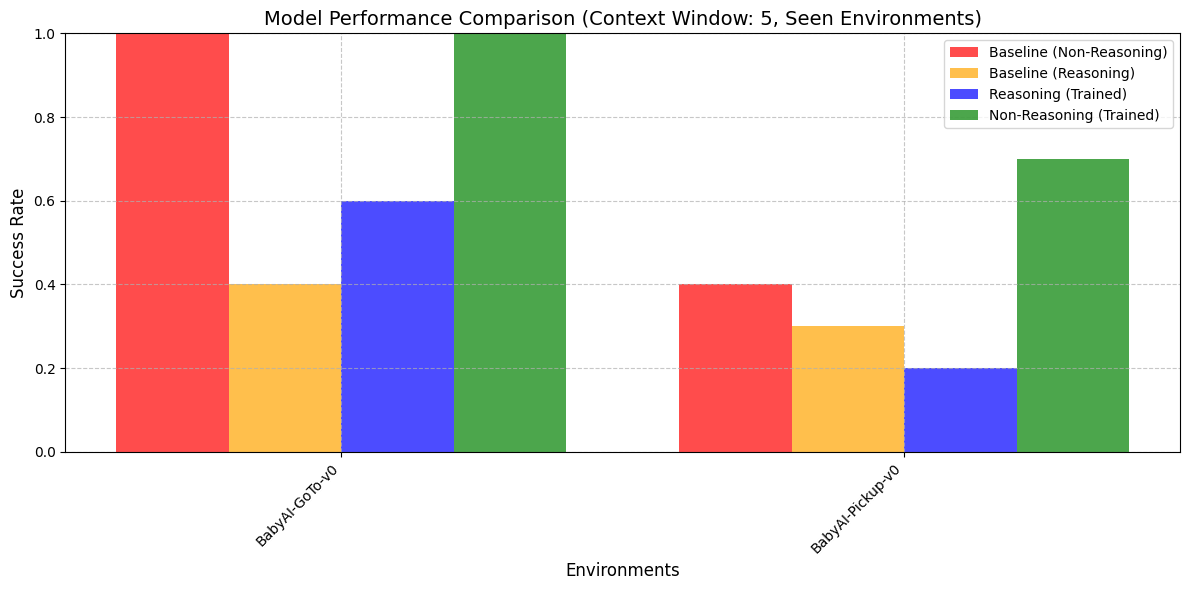

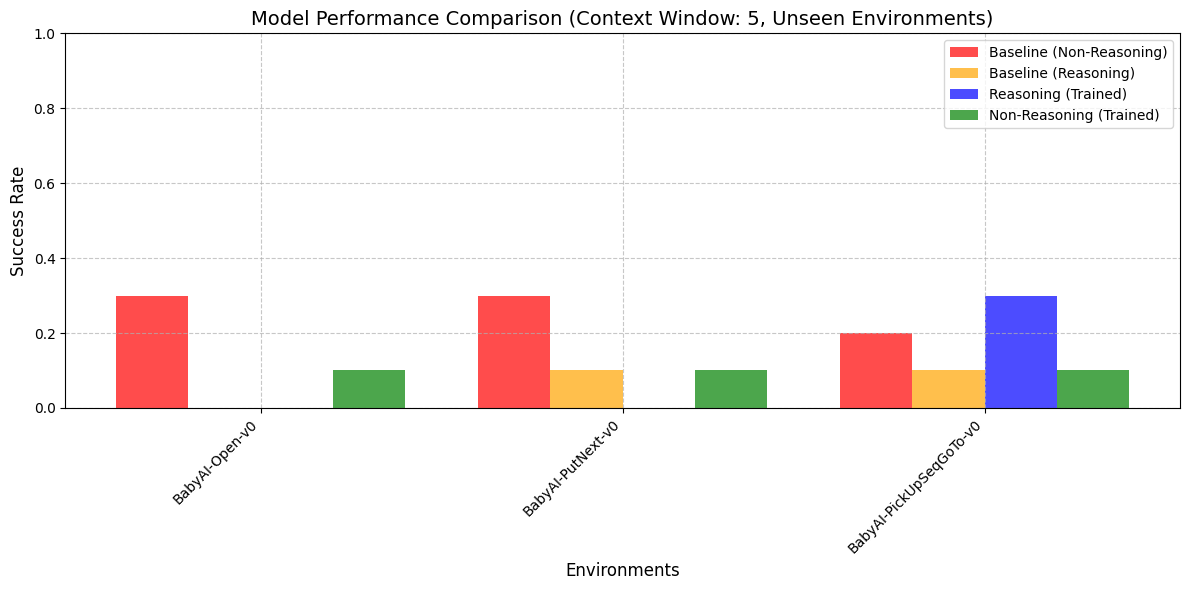

TypeError: Data source must be a DataFrame or Mapping, not <class 'list'>.

<Figure size 1400x700 with 0 Axes>

In [15]:
# Print summary statistics

# Display header
display(HTML("<h1>Evaluation Summary</h1>"))

# Print trained model results directly in notebook
for model_name, env_types in results.items():
    display(HTML(f"<h2>{model_name}</h2>"))
    
    for env_type, env_results in env_types.items():
        display(HTML(f"<h3>{env_type.capitalize()} Environments</h3>"))
        
        for env_id, context_results in env_results.items():
            display(HTML(f"<h4>{env_id}</h4>"))
            
            for cw, metrics in context_results.items():
                print(f"{model_name} on {env_id} ({env_type}) with context {cw}:")
                
                for metric_type, metric_values in metrics.items():
                    print(f"  {metric_type}:")
                    
                    for metric_name, value in metric_values.items():
                        std_key = f"{metric_name}_std"
                        if std_key in metric_values and not metric_name.endswith("_std"):
                            std_value = metric_values[std_key]
                            print(f"    {metric_name}: {value:.4f} ± {std_value:.4f}")

# Print baseline results
display(HTML("<h2>Baseline Model</h2>"))

for env_type in ["seen", "unseen"]:
    display(HTML(f"<h3>{env_type.capitalize()} Environments</h3>"))
    
    env_ids = seen_env_ids if env_type == "seen" else unseen_env_ids
    for env_id in env_ids:
        display(HTML(f"<h4>{env_id}</h4>"))
        
        print(f"llama-3.2-3b-baseline on {env_id} ({env_type}) with context {context_window}:")
        
        for metric_type in ["non_reasoning", "reasoning"]:
            print(f"  {metric_type}:")
            
            metric_values = baseline_results[env_type][env_id][context_window][metric_type]
            for metric_name, value in metric_values.items():
                if metric_name.endswith("_std"):
                    continue
                    
                std_key = f"{metric_name}_std"
                if std_key in metric_values:
                    std_value = metric_values[std_key]
                    print(f"    {metric_name}: {value:.4f} ± {std_value:.4f}")
                else:
                    print(f"    {metric_name}: {value:.4f}")

# Display comparison plots
display(HTML("<h2>Performance Comparisons</h2>"))

for model_name, env_types in results.items():
    display(HTML(f"<h3>Model: {model_name}</h3>"))
    
    # Seen environments
    display(HTML("<h4>Seen Environments</h4>"))
    
    seen_baseline_non_reasoning = {env_id: baseline_results["seen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in seen_env_ids}
    seen_baseline_reasoning = {env_id: baseline_results["seen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in seen_env_ids}
    seen_reasoning = {env_id: results[model_name]["seen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in seen_env_ids}
    seen_non_reasoning = {env_id: results[model_name]["seen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in seen_env_ids}
    
    fig, ax = plt.subplots(figsize=(12, 6))
    n_envs = len(seen_env_ids)
    bar_width = 0.2
    index = np.arange(n_envs)
    
    ax.bar(index - bar_width * 1.5, [seen_baseline_non_reasoning[env_id] for env_id in seen_env_ids], 
           bar_width, label="Baseline (Non-Reasoning)", color='red', alpha=0.7)
    ax.bar(index - bar_width * 0.5, [seen_baseline_reasoning[env_id] for env_id in seen_env_ids], 
           bar_width, label="Baseline (Reasoning)", color='orange', alpha=0.7)
    ax.bar(index + bar_width * 0.5, [seen_reasoning[env_id] for env_id in seen_env_ids], 
           bar_width, label="Reasoning (Trained)", color='blue', alpha=0.7)
    ax.bar(index + bar_width * 1.5, [seen_non_reasoning[env_id] for env_id in seen_env_ids], 
           bar_width, label="Non-Reasoning (Trained)", color='green', alpha=0.7)
    
    ax.set_xlabel("Environments", fontsize=12)
    ax.set_ylabel("Success Rate", fontsize=12)
    ax.set_title(f"Model Performance Comparison (Context Window: {context_window}, Seen Environments)", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(seen_env_ids, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Unseen environments
    display(HTML("<h4>Unseen Environments</h4>"))
    
    unseen_baseline_non_reasoning = {env_id: baseline_results["unseen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in unseen_env_ids}
    unseen_baseline_reasoning = {env_id: baseline_results["unseen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in unseen_env_ids}
    unseen_reasoning = {env_id: results[model_name]["unseen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in unseen_env_ids}
    unseen_non_reasoning = {env_id: results[model_name]["unseen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in unseen_env_ids}
    
    fig, ax = plt.subplots(figsize=(12, 6))
    n_envs = len(unseen_env_ids)
    bar_width = 0.2
    index = np.arange(n_envs)
    
    ax.bar(index - bar_width * 1.5, [unseen_baseline_non_reasoning[env_id] for env_id in unseen_env_ids], 
           bar_width, label="Baseline (Non-Reasoning)", color='red', alpha=0.7)
    ax.bar(index - bar_width * 0.5, [unseen_baseline_reasoning[env_id] for env_id in unseen_env_ids], 
           bar_width, label="Baseline (Reasoning)", color='orange', alpha=0.7)
    ax.bar(index + bar_width * 0.5, [unseen_reasoning[env_id] for env_id in unseen_env_ids], 
           bar_width, label="Reasoning (Trained)", color='blue', alpha=0.7)
    ax.bar(index + bar_width * 1.5, [unseen_non_reasoning[env_id] for env_id in unseen_env_ids], 
           bar_width, label="Non-Reasoning (Trained)", color='green', alpha=0.7)
    
    ax.set_xlabel("Environments", fontsize=12)
    ax.set_ylabel("Success Rate", fontsize=12)
    ax.set_title(f"Model Performance Comparison (Context Window: {context_window}, Unseen Environments)", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(unseen_env_ids, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Reasoning vs non-reasoning improvement
display(HTML("<h2>Reasoning vs Non-Reasoning Improvement</h2>"))

# Gather data for reasoning improvement visualization
improvement_data = []

for model_name, env_types in results.items():
    for env_type in ["seen", "unseen"]:
        env_ids = seen_env_ids if env_type == "seen" else unseen_env_ids
        for env_id in env_ids:
            reasoning_success = results[model_name][env_type][env_id][context_window]["reasoning"]["success_rate"]
            non_reasoning_success = results[model_name][env_type][env_id][context_window]["non_reasoning"]["success_rate"]
            improvement = reasoning_success - non_reasoning_success
            
            improvement_data.append({
                "Model": model_name,
                "Environment": env_id,
                "Environment Type": env_type.capitalize(),
                "Improvement": improvement
            })

# Same for baseline
for env_type in ["seen", "unseen"]:
    env_ids = seen_env_ids if env_type == "seen" else unseen_env_ids
    for env_id in env_ids:
        reasoning_success = baseline_results[env_type][env_id][context_window]["reasoning"]["success_rate"]
        non_reasoning_success = baseline_results[env_type][env_id][context_window]["non_reasoning"]["success_rate"]
        improvement = reasoning_success - non_reasoning_success
        
        improvement_data.append({
            "Model": "Baseline",
            "Environment": env_id,
            "Environment Type": env_type.capitalize(),
            "Improvement": improvement
        })

# Create bar chart of improvements
plt.figure(figsize=(14, 7))
ax = sns.barplot(x="Environment", y="Improvement", hue="Model", data=improvement_data)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title("Improvement from Reasoning vs Non-Reasoning")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
